# Forecasting NYC Traffic Accidents

## Using Autoregressive Integrated Moving Average

#### By William Outcault

### Summary

In summary, I want to visualize the impact COVID-19 had on the total number of NYC traffic accidents. This involved forecasting future months based off previous data not influenced by the pandemic. To complete the time-series forecasting necessary for the analysis I created an ARIMA model. The raw data includes data retrieved from 2013 to present-day aggregated by month. The link to find this data can be found below.

https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

### ARIMA models

To do the forecasting I created a Autoregressive Integrated Moving Average model. This model can be broken into three parts. 

First Autoregression (AR) refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.

Next Integrated (I) represents the differencing of raw observations to allow for the time series to become stationary. 

Lastly the Moving Average (MA) incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

### Raw Data

To begin we start by visualizing the data from 2013 through 2018. The testing data will be traffic accidents during 2019. For the training set there is a trend and seasonal bahavior however no cyclic behavior. The trend is positive and seems to level off in 2018.

In [39]:
import pandas as pd
import numpy as np
import math

import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib as mpl

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import pmdarima as pm
from pmdarima.arima import StepwiseContext

from datetime import datetime as dt

import warnings

In [10]:
Acquired data from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

df = pd.read_json('https://data.cityofnewyork.us/resource/h9gi-nx95.json?' +\
             '$where=crash_date>"2012-12-31T00:00:00.000"' +\
             '&$limit=2000000').replace(' ', '%20')

df.crash_date = pd.to_datetime(df.crash_date)
df = df['crash_date'].groupby(df.crash_date.dt.to_period("M")).agg('count')

In [28]:
df = pd.read_csv("https://raw.githubusercontent.com/willoutcault/NYC_Accidents_ARIMA_Forcast/master/Accidents.csv")
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])

warnings.filterwarnings('ignore')

train = df.iloc[:78,:]
test = df.iloc[77:90,:]

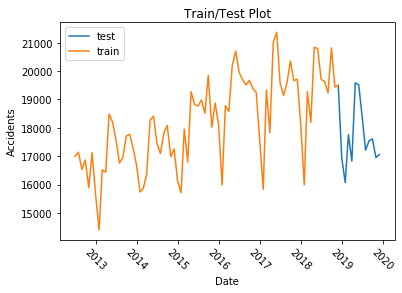

In [33]:
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.title("Train/Test Plot")
plt.xticks(rotation=-45)
plt.plot(test, label="test")
plt.plot(train, label="train")
plt.legend(loc="best")

### Stationarity

We want to begin by making the data stationary, specifically we want to show the data is consitence over time. To measure these we find the rolling mean and rolling standard deviation, and then run a Dickey-Fullter Test to calculate our test statistic. In general if our test statistic is larger than our critical values we can conclude that our data is stationary.

Before finding these values we take the log value of the differenced data points. Then we plot these trends and view our test statistic.

In our case our test statistic is larger than the critical values. In addition we notice the moving average remains around 0 which further shows stationary data.

In [34]:
def test_stationarity(timeseries):
    movingAverage = timeseries.rolling(window=12).mean()
    movingStd = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries, label='Original')
    mean = plt.plot(movingAverage, color='darkgreen', label='Rolling Mean')
    std = plt.plot(movingStd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Accidents'], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

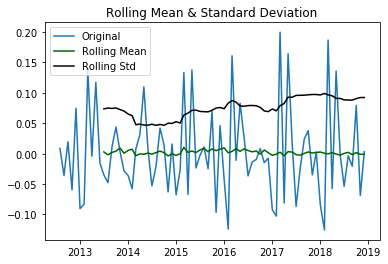

Results of Dickey-Fuller Test:
Test Statistic                 -4.341960
p-value                         0.000375
#Lags Used                     11.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [35]:
# Getting Log Value
train_logScale = np.log(train)
# Subtracting Rolling Average And STD
movingAverage = train.rolling(window=12).mean()
movingStd = train_logScale.rolling(window=12).std()
datasetLogScaleMinusMovingAverage = train_logScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
# Time-Shift The Data (1 Degree)
datasetLogDiffShifting = train_logScale - train_logScale.shift(1)
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [50]:
%%capture
# Optimizing Parameters (p,q,m)
smodel = pm.auto_arima(train_logScale['Accidents'], start_p=1, start_q=1,
                       test='adf',max_p=3, max_q=3, m=12, start_P=1, D=0, seasonal=True,
                       trace=True, error_action='ignore',suppress_warnings=True, 
                       stepwise=True);

### Optimizing Parameters

The next step will be to optimize our three parameters p, d and q.

p: the number of lag observations in the model; also known as the lag order.

d: the number of times that the raw observations are differenced; also known as the degree of differencing.

q: the size of the moving average window; also known as the order of the moving average.

###  Visualizing Our Predictions

After optimization we can predict the future number of accidents that will occur in NYC.

Our raw data is shown in blue and predicted data shown in green which includes a 95% confidence Interval. Our raw data shown ranges from 2013 through January 2020. Our model then predicts each month's total number of accidents for the remainder of 2020.

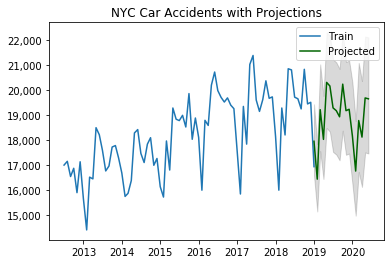

In [58]:
n_periods = 18
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[78], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig, ax = plt.subplots()
plt.plot(df[:79], label='Train')
plt.plot(np.exp(fitted_series), color='darkgreen', label='Projected')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.fill_between(lower_series.index, 
                 np.exp(lower_series), 
                 np.exp(upper_series), 
                 color='k', alpha=.15)
plt.legend(loc="best")
plt.title("NYC Car Accidents with Projections")
plt.show()

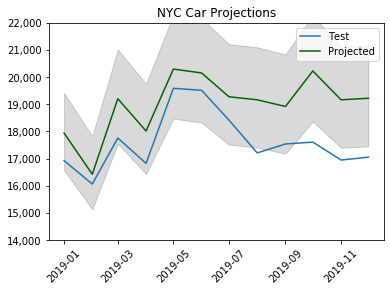

In [70]:
fig, ax = plt.subplots()
plt.plot(test[1:], label='Test')
plt.plot(np.exp(fitted_series[:12]), color='darkgreen', label='Projected')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.fill_between(lower_series.index[:12], 
                 np.exp(lower_series[:12]), 
                 np.exp(upper_series[:12]), 
                 color='k', alpha=.15)
plt.ylim([14000, 22000])
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.title("NYC Car Projections")
plt.show()

### Results

Our model's 2019 predictions had an absolute mean percent error just under 10%. Looking at the graph above there is a downward trend suggesting cyclic behavior which our model does not take into account. By acquiring previous data this can be implemented into the model for better performance.

In [52]:
fitted_series_exp = round(np.exp(fitted_series), 0)

arima_percent_change = (100*(df.values[78:96,0]/fitted_series_exp.values)-100)

dt = pd.DataFrame({"Month":df.index[78:96], "Projections":fitted_series_exp.values,
                   "Actual":df.values[78:96,0], "Percent Difference":arima_percent_change})

model_variance = round(np.mean(arima_percent_change[1:10]),2)

dt.head(12)

,Month,Projections,Actual,Percent Difference
0,2019-01-01,17942.0,16928,-5.651544
1,2019-02-01,16428.0,16067,-2.197468
2,2019-03-01,19206.0,17760,-7.528897
3,2019-04-01,18018.0,16828,-6.604507
4,2019-05-01,20297.0,19588,-3.493127
5,2019-06-01,20153.0,19515,-3.165782
6,2019-07-01,19278.0,18419,-4.455856
7,2019-08-01,19165.0,17212,-10.190451
8,2019-09-01,18921.0,17540,-7.298769
9,2019-10-01,20227.0,17609,-12.943096


In addition there may have been some effects from COVID-19 in the later months of 2019, however you see the dramatic effects start to occur in the start of 2020.

In [128]:
dt.tail(6)

,Month,Projections,Actual,Percent Difference
12,2020-01-01,18151.0,14276,-21.348686
13,2020-02-01,16752.0,13671,-18.391834
14,2020-03-01,18772.0,11021,-41.290219
15,2020-04-01,18110.0,4059,-77.586969
16,2020-05-01,19675.0,6106,-68.965693
17,2020-06-01,19639.0,6104,-68.918988


Using traffic accident information and fatality reports it would be interesting to see how the fatalities per accident changed. Using this information you can perhaps infer speeding habits during the COVID-19 pandemic. In addition, when NYC traffic becomes more regular we can perform more granular research in order to allocate NYPD officers towards time and locations with high projected accidents. 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')